In [2]:
import os
import json
import pickle
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms

In [3]:
image_path = '../Data/0325updated.task1train(626p)-20251119T175414Z-1-001/grayscale_standardized_data/X00016469612.png'

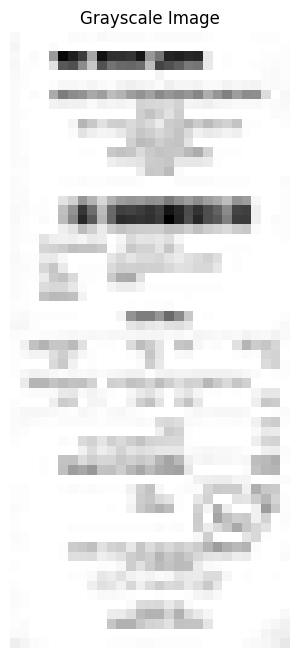

In [4]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  

plt.figure(figsize=(10, 8))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')
plt.show()

In [ ]:
img = cv2.imread(image_path)

if img is not None:
    height, width, channels = img.shape
    print(f"Image dimensions: {width} x {height} pixels")
    print(f"Number of channels: {channels}")
    print(f"Total pixels: {img.size}")
    print(f"Data type: {img.dtype}")
else:
    print("Image not found or couldn't be loaded")

Image dimensions: 29 x 64 pixels
Number of channels: 3
Total pixels: 5568
Data type: uint8


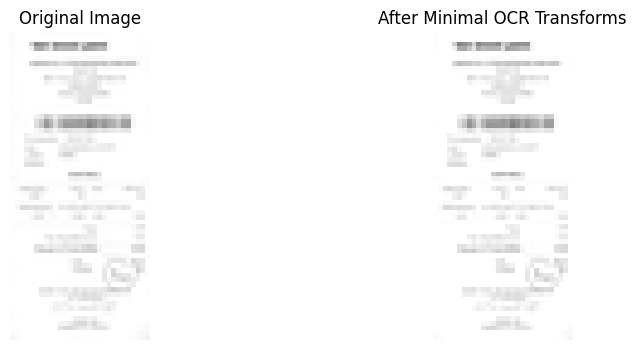

In [ ]:
def quick_visualization(image_path):
    # Load and transform
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transformed = minimal_ocr_transforms(img_rgb)
    
    # Convert back for display
    transformed_display = transformed.numpy().transpose(1, 2, 0)
    transformed_display = (transformed_display * 0.5) + 0.5
    
    # Display both
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(transformed_display)
    plt.title('After Minimal OCR Transforms')
    plt.axis('off')
    
    plt.show()
    
    return transformed

# Quick view
transformed = quick_visualization(image_path)

In [11]:

# GRAYSCALE OCR TRANSFORMS 
def get_grayscale_ocr_transforms(augment=True):
    """
    Get transforms for grayscale OCR images
    
    Args:
        augment: If True, apply mild augmentations
    
    Returns:
        transforms.Compose object
    """
    if augment:
        # Training: Mild augmentations that preserve text readability
        return transforms.Compose([
            transforms.ToTensor(),  
            
            # Mild brightness and contrast variations
            # (simulates different lighting conditions, scanner settings)
            transforms.ColorJitter(
                brightness=0.05,    # ±5% brightness
                contrast=0.05,      # ±5% contrast
            ),
            
            # Normalize to [-1, 1] for better training
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
    else:
        # Validation/Test: No augmentation
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])


In [12]:
import os
import json
import pickle
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms

class TextRecognitionDataset(Dataset):
    """
    Dataset for text recognition with variable-width images
    """
    def __init__(self, data_dir, vocab_path, transform=None, augment=False):
        """
        Args:
            data_dir: Directory containing images and text files
            vocab_path: Path to vocabulary.pkl file
            transform: Optional image transforms (overrides default and augment)
            augment: If True, apply mild augmentations for training
        """
        self.data_dir = data_dir
        self.augment = augment
        
        # Load vocabulary
        with open(vocab_path, 'rb') as f:
            vocab_data = pickle.load(f)
        
        self.char_to_idx = vocab_data['char_to_idx']
        self.idx_to_char = vocab_data['idx_to_char']
        self.vocab_size = vocab_data['vocab_size']
        
        # Get all image files
        self.image_files = sorted([
            f for f in os.listdir(data_dir) 
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))
        ])
        
        # Verify each image has a corresponding text file
        missing_texts = []
        for img_file in self.image_files:
            base_name = os.path.splitext(img_file)[0]
            txt_file = f"{base_name}.txt"
            txt_path = os.path.join(data_dir, txt_file)
            if not os.path.exists(txt_path):
                missing_texts.append(img_file)
        
        if missing_texts:
            print(f"\n⚠️  WARNING: {len(missing_texts)} images missing text files:")
            for img in missing_texts[:5]:  # Show first 5
                print(f"   - {img}")
            if len(missing_texts) > 5:
                print(f"   ... and {len(missing_texts) - 5} more")
            raise ValueError(f"Found {len(missing_texts)} images without matching text files!")
        
        # Set up transforms
        if transform is not None:
            # Use custom transform
            self.transform = transform
        elif augment:
            # Training with mild augmentations (for grayscale)
            self.transform = transforms.Compose([
                transforms.ToTensor(),  # Converts to [0, 1]
                transforms.ColorJitter(
                    brightness=0.05,    # Minimal brightness variation
                    contrast=0.05,      # Minimal contrast variation
                ),
                transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
            ])
        else:
            # Validation/Test: No augmentation
            self.transform = transforms.Compose([
                transforms.ToTensor(),  # Converts to [0, 1] and CHW format
                transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
            ])
        
        print(f"Dataset initialized:")
        print(f"  Images: {len(self.image_files)}")
        print(f"  Vocabulary size: {self.vocab_size}")
        print(f"  Augmentation: {'✓ Enabled' if augment else '✗ Disabled'}")
    
    def __len__(self):
        return len(self.image_files)
    
    def encode_text(self, text):
        """Convert text to indices"""
        return [self.char_to_idx.get(char, 0) for char in text]
    
    def decode_text(self, indices):
        """Convert indices back to text"""
        return ''.join([self.idx_to_char.get(idx, '') for idx in indices])
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.data_dir, img_name)
        image = Image.open(img_path).convert('L')  # Ensure grayscale
        
        # Load corresponding text file
        # Get base name without extension (handles .png, .jpg, .jpeg, etc.)
        base_name = os.path.splitext(img_name)[0]
        txt_name = f"{base_name}.txt"
        txt_path = os.path.join(self.data_dir, txt_name)
        
        # Read text file with error handling
        try:
            with open(txt_path, 'r', encoding='utf-8') as f:
                text = f.read().strip()
        except FileNotFoundError:
            raise FileNotFoundError(f"Text file not found for image: {img_name}\nExpected: {txt_path}")
        except UnicodeDecodeError:
            # Try different encoding if utf-8 fails
            with open(txt_path, 'r', encoding='latin-1') as f:
                text = f.read().strip()
        
        # Transform image (includes normalization)
        if self.transform:
            image = self.transform(image)
        
        # Encode text
        encoded_text = self.encode_text(text)
        
        return {
            'image': image,
            'text': text,
            'encoded_text': torch.tensor(encoded_text, dtype=torch.long),
            'text_length': len(encoded_text),
            'image_width': image.shape[2]  # Width of transformed image
        }


def collate_fn(batch):
    """
    Custom collate function to handle variable-width images and text lengths
    Pads images and text to the maximum size in the batch
    """
    # Sort batch by image width (helps with efficient padding)
    batch = sorted(batch, key=lambda x: x['image_width'], reverse=True)
    
    # Get max dimensions in batch
    max_width = max([item['image'].shape[2] for item in batch])
    max_text_length = max([item['text_length'] for item in batch])
    
    # Prepare lists
    images = []
    encoded_texts = []
    text_lengths = []
    original_texts = []
    
    for item in batch:
        # Pad image width
        img = item['image']
        width_padding = max_width - img.shape[2]
        if width_padding > 0:
            # Pad right side with zeros (black)
            padded_img = torch.nn.functional.pad(img, (0, width_padding, 0, 0))
        else:
            padded_img = img
        images.append(padded_img)
        
        # Pad text
        encoded = item['encoded_text']
        text_padding = max_text_length - len(encoded)
        if text_padding > 0:
            padded_text = torch.nn.functional.pad(encoded, (0, text_padding), value=0)
        else:
            padded_text = encoded
        encoded_texts.append(padded_text)
        
        text_lengths.append(item['text_length'])
        original_texts.append(item['text'])
    
    return {
        'images': torch.stack(images),  # [batch, 1, height, max_width]
        'encoded_texts': torch.stack(encoded_texts),  # [batch, max_text_length]
        'text_lengths': torch.tensor(text_lengths),
        'original_texts': original_texts
    }


def create_dataloaders(data_dir, vocab_path, batch_size=32, train_split=0.8, num_workers=4, augment_train=True):
    """
    Create train and validation dataloaders
    
    Args:
        data_dir: Directory with preprocessed images and texts
        vocab_path: Path to vocabulary.pkl
        batch_size: Batch size for training
        train_split: Fraction of data for training
        num_workers: Number of workers for data loading
        augment_train: If True, apply augmentations to training data
    
    Returns:
        train_loader, val_loader, dataset
    """
    # Create full dataset for splitting
    full_dataset_for_split = TextRecognitionDataset(data_dir, vocab_path, augment=False)
    
    # Split into train/val
    dataset_size = len(full_dataset_for_split)
    train_size = int(train_split * dataset_size)
    val_size = dataset_size - train_size
    
    train_indices, val_indices = torch.utils.data.random_split(
        range(dataset_size), 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )
    
    # Create separate datasets with different augmentation settings
    train_dataset = TextRecognitionDataset(data_dir, vocab_path, augment=augment_train)
    val_dataset = TextRecognitionDataset(data_dir, vocab_path, augment=False)
    
    # Apply indices to subset the data
    train_dataset = torch.utils.data.Subset(train_dataset, train_indices.indices)
    val_dataset = torch.utils.data.Subset(val_dataset, val_indices.indices)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True  
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True
    )
    
    print(f"\nDataLoader created:")
    print(f"  Training samples: {train_size} {'(with augmentation)' if augment_train else ''}")
    print(f"  Validation samples: {val_size} (no augmentation)")
    print(f"  Batch size: {batch_size}")
    
    return train_loader, val_loader, full_dataset_for_split

if __name__ == "__main__":
    # Paths
    DATA_DIR = '../Data/0325updated.task1train(626p)-20251119T175414Z-1-001/good_data/grayscale_standardized_data/'
    VOCAB_PATH = '../Data/vocabulary/vocabulary.pkl'
    
    # Create dataloaders
    train_loader, val_loader, dataset = create_dataloaders(
        data_dir=DATA_DIR,
        vocab_path=VOCAB_PATH,
        batch_size=16,
        train_split=0.8,
        augment_train=True  
    )
    
    # Test loading a batch
    print("\n" + "="*60)
    print("TESTING DATALOADER")
    print("="*60)
    
    batch = next(iter(train_loader))
    
    print(f"\nBatch shapes:")
    print(f"  Images: {batch['images'].shape}")  # [batch, 1, 64, max_width]
    print(f"  Encoded texts: {batch['encoded_texts'].shape}")  # [batch, max_text_length]
    print(f"  Text lengths: {batch['text_lengths'].shape}")
    
    print(f"\nBatch statistics:")
    print(f"  Image pixel range: [{batch['images'].min():.3f}, {batch['images'].max():.3f}]")
    print(f"  Normalized: {'✓' if batch['images'].min() < 0 else '✗'}")
    
    print(f"\nSample data:")
    for i in range(min(3, len(batch['original_texts']))):
        print(f"  {i+1}. Text: '{batch['original_texts'][i]}'")
        print(f"     Encoded: {batch['encoded_texts'][i][:10].tolist()}...")
        print(f"     Length: {batch['text_lengths'][i].item()}")
        print(f"     Image size: {batch['images'][i].shape}")
    
    print("\n" + "="*60)
    print("✅ Dataset and DataLoader ready for training!")
    print("="*60)

Dataset initialized:
  Images: 704
  Vocabulary size: 75
  Augmentation: ✗ Disabled
Dataset initialized:
  Images: 704
  Vocabulary size: 75
  Augmentation: ✓ Enabled
Dataset initialized:
  Images: 704
  Vocabulary size: 75
  Augmentation: ✗ Disabled

DataLoader created:
  Training samples: 563 (with augmentation)
  Validation samples: 141 (no augmentation)
  Batch size: 16

TESTING DATALOADER

Batch shapes:
  Images: torch.Size([16, 1, 64, 45])
  Encoded texts: torch.Size([16, 3807])
  Text lengths: torch.Size([16])

Batch statistics:
  Image pixel range: [-1.000, 1.000]
  Normalized: ✓

Sample data:
  1. Text: '196,164,654,164,654,210,196,210,NADEJE PLATINUM SDN BHD
43,216,792,216,792,256,43,256,GK101,GND FLR,ONE UTAMA SHOPPING CENTRE
175,262,659,262,659,301,175,301,NO.1,LEBUH BANDAR UTAMA,
142,305,713,305,713,345,142,345,47800 PETALING JAYA, SELANGOR.
274,348,584,348,584,389,274,389,TEL:03-7710 0302
233,393,608,393,608,436,233,436,GST ID:001151160320
39,570,433,570,433,609,39,609,BI

In [13]:
import os
import glob

data_dir = '../Data/0325updated.task1train(626p)-20251119T175414Z-1-001/good_data/grayscale_standardized_data/'
txt_files = glob.glob(os.path.join(data_dir, '*.txt'))

text_lengths = []
for txt_file in txt_files:
    with open(txt_file, 'r', encoding='utf-8') as f:
        text = f.read().strip()
        text_lengths.append((len(text), os.path.basename(txt_file), text[:100]))  # First 100 chars

# Sort by length
text_lengths.sort(reverse=True)

print("="*60)
print("TEXT LENGTH ANALYSIS")
print("="*60)
print(f"\nTop 10 longest text files:")
for length, filename, preview in text_lengths[:10]:
    print(f"\n{length:5d} chars - {filename}")
    print(f"   Preview: {preview}...")

print(f"\n📊 Statistics:")
lengths_only = [l for l, _, _ in text_lengths]
print(f"   Min: {min(lengths_only)} chars")
print(f"   Max: {max(lengths_only)} chars")
print(f"   Average: {sum(lengths_only)/len(lengths_only):.1f} chars")
print(f"   Median: {sorted(lengths_only)[len(lengths_only)//2]} chars")

# Distribution
import numpy as np
print(f"\n📈 Distribution:")
print(f"   Under 10 chars: {sum(1 for l in lengths_only if l < 10)}")
print(f"   10-50 chars: {sum(1 for l in lengths_only if 10 <= l < 50)}")
print(f"   50-100 chars: {sum(1 for l in lengths_only if 50 <= l < 100)}")
print(f"   100-500 chars: {sum(1 for l in lengths_only if 100 <= l < 500)}")
print(f"   Over 500 chars: {sum(1 for l in lengths_only if l >= 500)}")

TEXT LENGTH ANALYSIS

Top 10 longest text files:

 6672 chars - X51005663297.txt
   Preview: 93,263,833,263,833,318,93,318,BEYOND BROTHERS HARDWARE
379,313,558,313,558,349,379,349,(872981-V)
30...

 6607 chars - X51007846368.txt
   Preview: 1462,915,2933,915,2933,1014,1462,1014,GRANDMA HOMES RESTAURANT
1927,1029,2471,1029,2471,1117,1927,11...

 5671 chars - X51006414713.txt
   Preview: 1914,779,2637,779,2637,865,1914,865,YHM AEON TEBRAU CITY
1919,868,2593,868,2593,953,1919,953,S117, S...

 5423 chars - X51007846305.txt
   Preview: 1938,364,2515,364,2515,457,1938,457,AEON CO. (M) BHD
2548,349,2897,349,2897,446,2548,446,(126926-H)
...

 5114 chars - X51005806679.txt
   Preview: 236,306,772,306,772,347,236,347,LEE WAH FLORIST SDN BHD
430,345,586,345,586,377,430,377,(521273-W)
3...

 5062 chars - X51005268472.txt
   Preview: 319,78,526,78,526,118,319,118,ASIA MART
320,113,516,113,516,150,320,150,(SA0264195-T)
190,137,643,13...

 4997 chars - X51005663324.txt
   Preview: 87,207,845,207,845,